In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
import itertools
import joblib

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded.')


Modules loaded.


In [ ]:
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/BUSI/Dataset_BUSI_with_GT'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)


In [ ]:
df

filepaths     labels
0    /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...  malignant
1    /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...  malignant
2    /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...  malignant
3    /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...  malignant
4    /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...  malignant
..                                                 ...        ...
965  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     benign
966  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     benign
967  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     benign
968  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     benign
969  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     benign

[970 rows x 2 columns]

In [ ]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
test_df

filepaths     labels
805  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     benign
755  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     benign
532  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     normal
238  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...  malignant
29   /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...  malignant
..                                                 ...        ...
7    /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...  malignant
917  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     benign
818  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     benign
646  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     normal
580  /content/drive/MyDrive/BUSI/Dataset_BUSI_with_...     normal

[194 rows x 2 columns]

In [ ]:
# Load DenseNet201 model for feature extraction
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Unfreeze the last few layers of DenseNet201
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Function to load and preprocess images
def load_and_preprocess_images(filepaths, img_size=(224, 224)):
    images = []
    for filepath in filepaths:
        img = cv2.imread(filepath)
        img = cv2.resize(img, img_size)
        img = img.astype('float32')  # Convert to float32
        img = preprocess_input(img)  # Preprocess for DenseNet201
        images.append(img)
    return np.array(images)

# Load training and testing images
X_train = load_and_preprocess_images(train_df['filepaths'].values)
y_train = train_df['labels'].values
X_test = load_and_preprocess_images(test_df['filepaths'].values)
y_test = test_df['labels'].values


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Extract features using efficient net b3
X_train_features = base_model.predict(X_train)
X_test_features = base_model.predict(X_test)

# Flatten the features
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 233s 9s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step


In [ ]:
# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [ ]:
# Train the SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=43, probability=True)  # Enable probability for ROC curve
svm_model.fit(X_train_features, y_train_encoded)


SVC(kernel='linear', probability=True, random_state=43)

In [ ]:
# Make predictions
y_pred = svm_model.predict(X_test_features)
y_pred_proba = svm_model.predict_proba(X_test_features)  # Probabilities for ROC curve

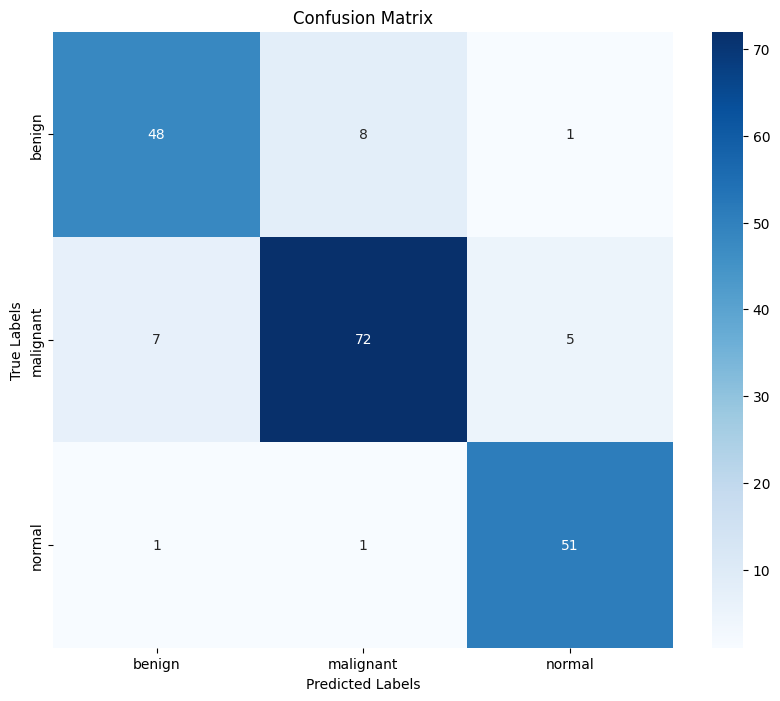

In [ ]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

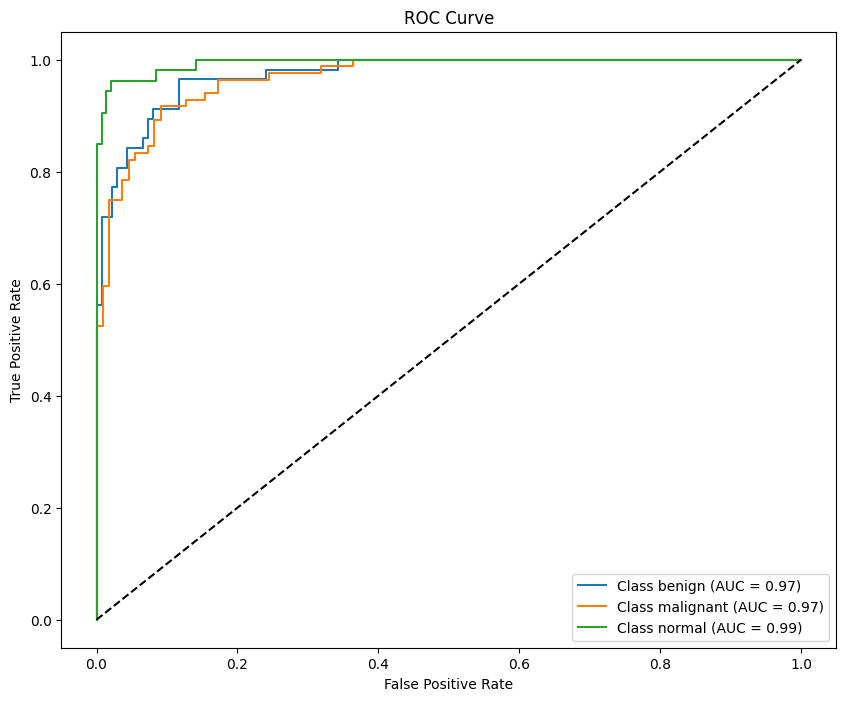

In [ ]:
# 2. ROC Curve and AUC Score
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_encoded == i, y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

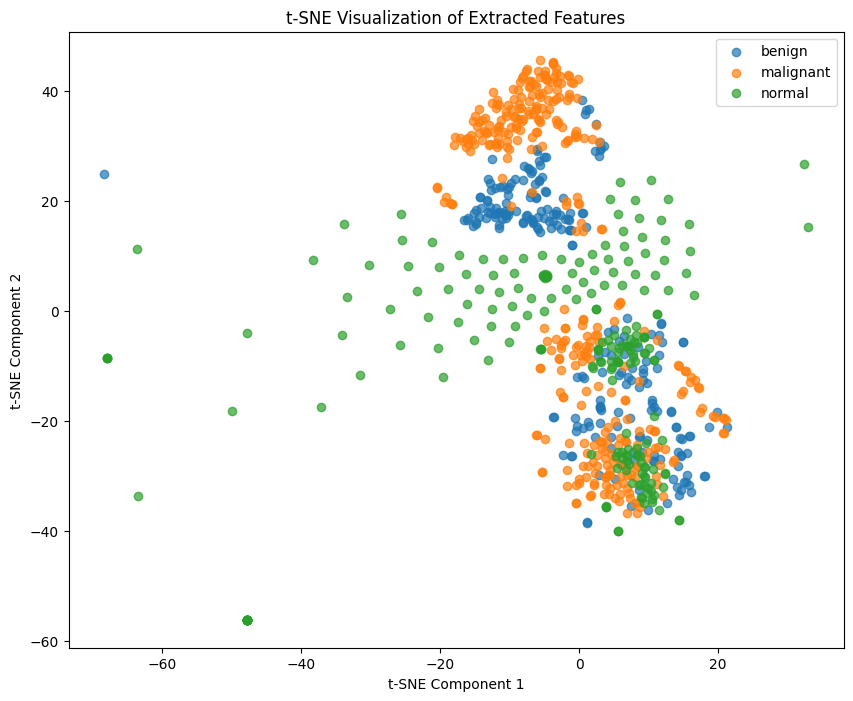

In [ ]:
# 4. t-SNE Visualization of Extracted Features
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_features)

plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    indices = np.where(y_train_encoded == i)
    plt.scatter(X_train_tsne[indices, 0], X_train_tsne[indices, 1], label=le.classes_[i], alpha=0.7)
plt.title('t-SNE Visualization of Extracted Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

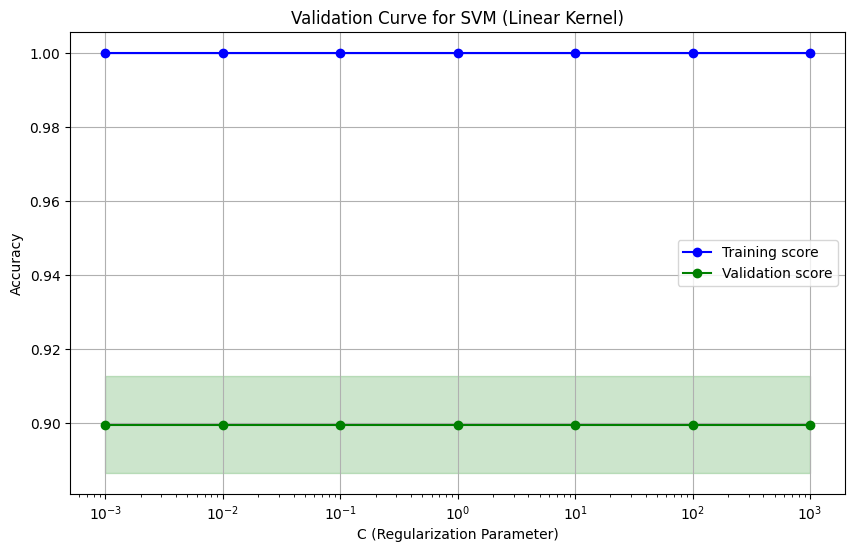

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Define range of C values to test
param_range = np.logspace(-3, 3, 7)

# Generate training and validation scores using validation_curve
train_scores, valid_scores = validation_curve(
    SVC(kernel='linear'),
    X_train_features, y_train_encoded,
    param_name="C",
    param_range=param_range,
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker='o')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)

plt.plot(param_range, valid_mean, label="Validation score", color="green", marker='o')
plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, color="green", alpha=0.2)

plt.xscale('log')
plt.title("Validation Curve for SVM (Linear Kernel)")
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [ ]:
# Classification report
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

      benign       0.96      0.96      0.96       179
   malignant       0.95      0.92      0.93        84
      normal       0.95      0.98      0.96        53

    accuracy                           0.95       316
   macro avg       0.95      0.95      0.95       316
weighted avg       0.95      0.95      0.95       316



In [ ]:
# Save the model using joblib
import joblib
joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']